# Gaussian Process

In this notebook, we will implement a Gaussian Process model from scratch.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds
from pyDOE import lhs
import seaborn as sns
import pandas as pd

%matplotlib inline

In [99]:
class GaussianProcess:
    """A Gaussian Process class that trains and predicts 
    with a Gaussian Process model"""
    
    def __init__(self, n_restarts, optimizer, bounds):
        """Initialize a Gaussian Process model
        
        Input
        ------
        n_restarts: number of restarts of the local optimizer
        optimizer: algorithm of local optimization
        bounds: Bounds for GP model parameter theta"""
        
        self.n_restarts = n_restarts
        self.optimizer = optimizer
        self.bounds = bounds
        
    def likelihood(self, theta):
        """Likelihood function
        
        Input
        -----
        theta: correlation length"""
        
        theta = 10**theta    # Correlation length
        n = self.X.shape[0]       # Number of training instances
        one = np.ones((n,1))      # A vector of ones
        
        # Construct correlation matrix
        Psi = np.zeros((n,n))
        for i in range(n-1):
            for j in range(i+1,n):
                Psi[i,j] = np.exp(-np.sum(theta*(self.X[i,:]-self.X[j,:])**2))
        Psi = Psi + Psi.T + np.eye(n) + np.eye(n)*1e-10
        
        # Mean estimation
        mu = (one.T @ np.linalg.inv(Psi) @ self.y)/ (one.T @ np.linalg.inv(Psi) @ one)
        
        # Variance estimation
        SigmaSqr = (self.y-mu*one).T @ np.linalg.inv(Psi) @ (self.y-mu*one) / n
        
        # Compute log-likelihood
        DetPsi = np.linalg.det(Psi)
        LnLike = -(n/2)*np.log(SigmaSqr) - 0.5*np.log(DetPsi)
        
        # Update attributes
        self.Psi, self.mu, self.SigmaSqr = Psi, mu, SigmaSqr
        
        return -LnLike.flatten()
        
        
    def fit(self, X, y):
        """GP model training
        
        Input
        -----
        X: 2D array of shape (n_samples, n_features)
        y: 2D array of shape (n_samples, 1)
        """
        
        self.X, self.y = X, y
        
        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)
        # Scale random samples to the given bounds 
        lb, ub = self.bounds[0], self.bounds[1]
        initial_points = (ub-lb)*lhd + lb
        
        # Create A Bounds instance for optimization
        bnds = Bounds(lb,ub)
        
        # Run local optimizer on all points
        self.opt_para, self.opt_func = np.zeros(self.n_restarts), np.zeros(self.n_restarts)
        for i,point in enumerate(initial_points):
            res = minimize(self.likelihood, point, method=self.optimizer,
                bounds=bnds)
            self.opt_para[i] = res.x
            self.opt_func[i] = res.fun
        
        # Locate the optimum results
        self.theta = self.opt_para[np.argmin(self.opt_func)]
        
        # Update GP attributes
        self.LnLike = -self.likelihood(self.theta)
    
    def predict(self, X_test):
        """GP model predicting
        
        Input
        -----
        X_test: Prediction sites"""
        
        theta = 10**self.theta
        n = self.X.shape[0]
        one = np.ones((n,1))
        
        # Construct correlation matrix between test and train data
        psi=np.zeros((n,X_test.shape[0]))
        for i in range(n):
            for j in range(X_test.shape[0]):
                psi[i,j] = np.exp(-np.sum(theta*(self.X[i,:]-X_test[j,:])**2))
        
        # Mean prediction
        f = self.mu + psi.T @ np.linalg.inv(self.Psi) @ (self.y-self.mu*one)
        
        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(psi.T @ np.linalg.inv(self.Psi) @ psi))
        
        return f.flatten(), SSqr.flatten()

# Test function

## 1D Test

In [100]:
def test_function(x):
    """1D Test Function"""
    
    y = (x*6-2)**2*np.sin(x*12-4)
    
    return y

In [101]:
# Training data
X_train = np.array([0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1], ndmin=2).T
y_train = test_function(X_train)

# Testing data
X_test = np.linspace(0.0, 1, 100).reshape(-1,1)
y_test = test_function(X_test)

In [102]:
# GP model training
GP = GaussianProcess(n_restarts=30, optimizer='L-BFGS-B', bounds=(-3,2))
GP.fit(X_train, y_train)

# GP model predicting
y_pred, y_pred_SSqr = GP.predict(X_test)

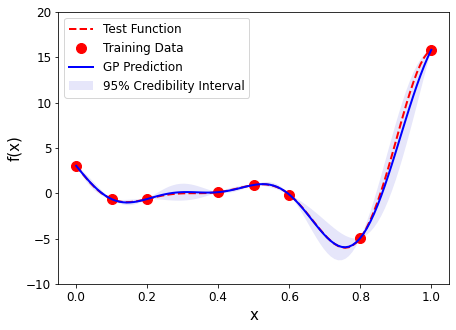

In [103]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test,y_test,'r--',linewidth=2,label='Test Function')
ax.plot(X_train,y_train,'ro',markerfacecolor='r', markersize=10, label='Training Data')
ax.plot(X_test,y_pred,'b-', lw=2, label='GP Prediction')
ax.fill_between(X_test.flatten(), y_pred-1.96*np.sqrt(y_pred_SSqr), 
                y_pred+1.96*np.sqrt(y_pred_SSqr),
                facecolor='lavender',label='95% Credibility Interval')
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.plot(X_test,y_pred+1.96*np.sqrt(y_pred_SSqr),'b--', lw=1.2, label='95% Confidence Interval')
# ax.plot(X_test,y_pred-1.96*np.sqrt(y_pred_SSqr),'b--', lw=1.2)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('f(x)', fontsize=15)
ax.set_ylim([-10,20])
ax.legend(loc="upper left",prop={'size': 12});

## 2D Test